#### Import Package

In [1]:
import os
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt

from core.system import *
from core.operation import *

import warnings

warnings.filterwarnings('ignore')

#### Load Data

In [12]:
# Params
start = '2005-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

In [13]:
# Read in ETF data from FMP
T = [1]
sector_ret = get_data_fmp(ticker_list=etf_list, start=start, current_date=current_date)
sector_ret = sector_ret[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret = sector_ret.rename(columns={'Adj Close': 'Close'})
sector_ret = sector_ret.loc[~sector_ret.index.duplicated(keep='first')]

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.65s/ticker]


In [14]:
# # Read in ETF data from FMP
# sector_fund = get_fund_fmp(ticker_list=etf_list, start=start, current_date=current_date)

In [ ]:
# Create returns
sector_ret = create_return(sector_ret, T)
sector_ret = sector_ret.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret = sector_ret.dropna()

#### Correlation

In [20]:
def corr_table(df):
    df = df.unstack('ticker').swaplevel(axis=1)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.fillna(0)
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    correlation_matrix_masked = correlation_matrix.mask(mask)
    formatted_corr_matrix = correlation_matrix_masked.applymap(lambda x: f"{x:.4f}" if np.isfinite(x) else "")
    return formatted_corr_matrix

In [21]:
corr_table(sector_ret)

,XLB_RET_01,XLE_RET_01,XLF_RET_01,XLI_RET_01,XLK_RET_01,XLP_RET_01,XLU_RET_01,XLV_RET_01,XLY_RET_01
XLB_RET_01,,,,,,,,,
XLE_RET_01,0.7557,,,,,,,,
XLF_RET_01,0.7364,0.6296,,,,,,,
XLI_RET_01,0.8664,0.7165,0.8059,,,,,,
XLK_RET_01,0.7471,0.5859,0.7014,0.7942,,,,,
XLP_RET_01,0.6505,0.5089,0.6278,0.7160,0.6787,,,,
XLU_RET_01,0.5795,0.5180,0.5148,0.6022,0.5496,0.7052,,,
XLV_RET_01,0.6882,0.5475,0.6418,0.7407,0.7212,0.7348,0.6104,,
XLY_RET_01,0.7611,0.5865,0.7668,0.8325,0.8444,0.6872,0.5371,0.7022,


#### Statistics

In [123]:
# Unstack 
stat = sector_ret.unstack('ticker')['RET_01']

In [139]:
# Get positive/negative return count
pos = []
neg = []
tickers = []
for ticker in stat.columns:
    pos.append(len(stat.loc[stat[ticker] > 0]))
    neg.append(len(stat.loc[stat[ticker] < 0]))
    tickers.append(ticker)
pos_neg_ret = pd.DataFrame(data={'pos':pos, 'neg':neg}, index=tickers)
pos_neg_ret

,pos,neg
XLB,2559,2202
XLE,2507,2279
XLF,2460,2247
XLI,2591,2163
XLK,2618,2124
XLP,2548,2154
XLU,2565,2170
XLV,2557,2183
XLY,2588,2180


#### Beta Premia

In [88]:
# Read in SPY data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=current_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/ticker]


In [89]:
# Create returns and unstack dataframe to only have 'date' index
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

In [164]:
# Execute Rolling OLS
T = [1]
window = 21
ret = f'RET_01'
factor_col_spy = spy.columns
beta_spy = rolling_ols_parallel(data=sector_ret, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')
defense = beta_spy[[f'SPY_RET_01_spy_01_{window}']]
defense.columns = ['beta']
defense = defense.dropna()

#### Momentum Premia

In [172]:
mom = sector_ret.copy(deep=True)

In [173]:
mom

RET_01
ticker date                
XLB    2005-01-04 -0.018135
       2005-01-05 -0.013720
       2005-01-06  0.006956
       2005-01-07  0.001594
       2005-01-10  0.004244
...                     ...
XLY    2024-02-26  0.003089
       2024-02-27  0.003299
       2024-02-28  0.003946
       2024-02-29  0.006770
       2024-03-01  0.003199

[43398 rows x 1 columns]

#### EWP Long-Only Portfolio

In [165]:
# EWP
ewp_weight = 1 / len(sector_ret.index.get_level_values('ticker').unique())
ewp_ret = sector_ret.groupby('date').apply(lambda x: (ewp_weight * x['RET_01']).sum())

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-05   2005-01-05
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          331.58%      534.48%
CAGR﹪                     5.41%        6.88%

Sharpe                     0.49         0.61
Prob. Sharpe Ratio         98.42%       99.59%
Smart Sharpe               0.45         0.55
Sortino                    0.69         0.85
Smart Sortino              0.63         0.77
Sortino/√2                 0.49         0.6
Smart Sortino/√2           0.44         0.55
Omega                      1.13         1.13

Max Drawdown               -56.47%      -52.53%
Longest DD Days            1982         1220
Volatility (ann.)          19.31%       18.77%
R^2                        0.96         0.96
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-15,2009-03-09,2011-02-15,1220,-52.530458,-47.929190
2,2020-02-20,2020-03-23,2020-11-06,261,-36.904274,-31.774678
3,2011-07-08,2011-10-03,2012-02-02,210,-18.614514,-16.957158
4,2018-09-24,2018-12-24,2019-04-11,200,-18.470306,-15.143610
5,2022-03-30,2022-09-30,2023-07-11,469,-16.943431,-16.049988


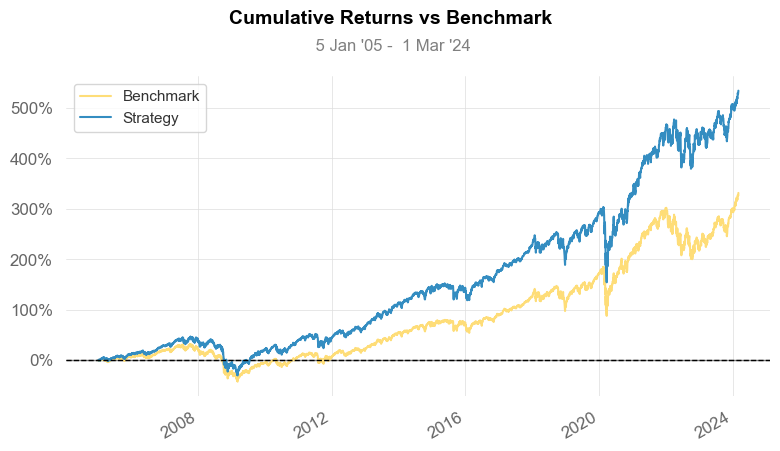

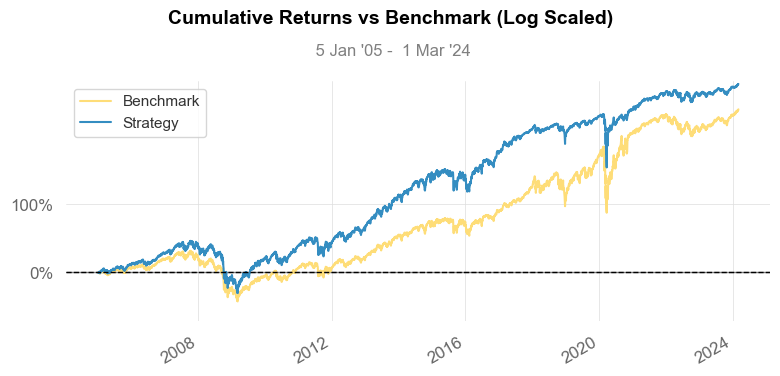

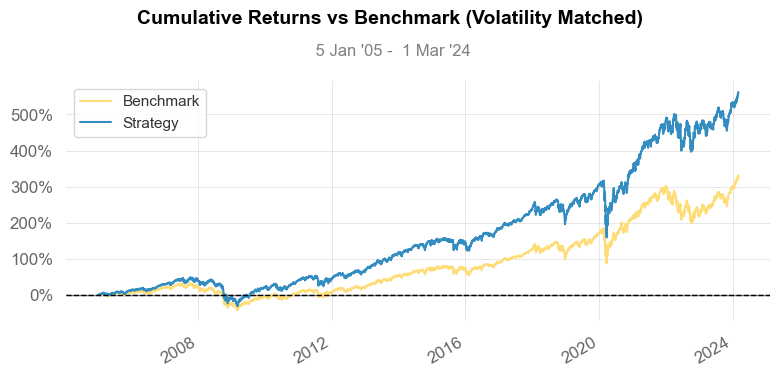

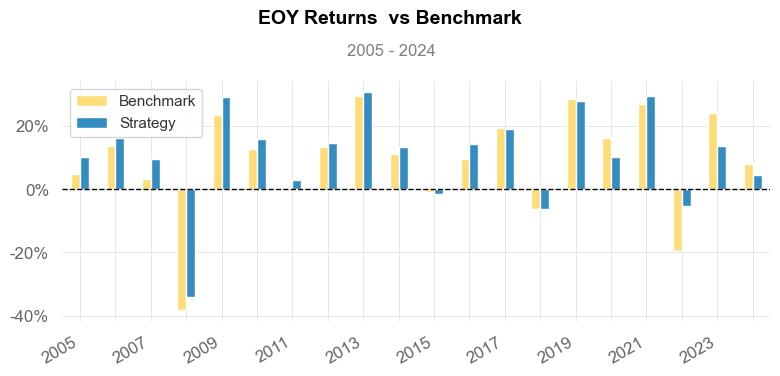

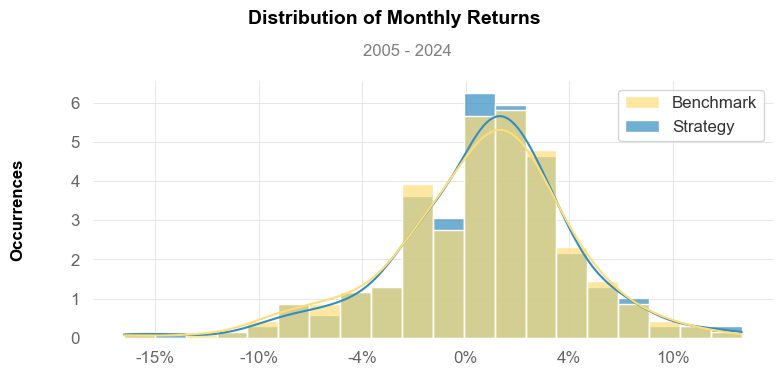

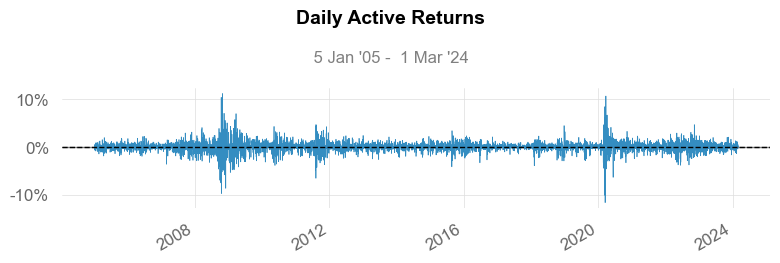

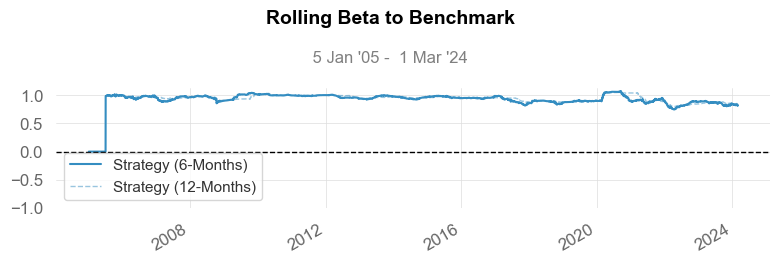

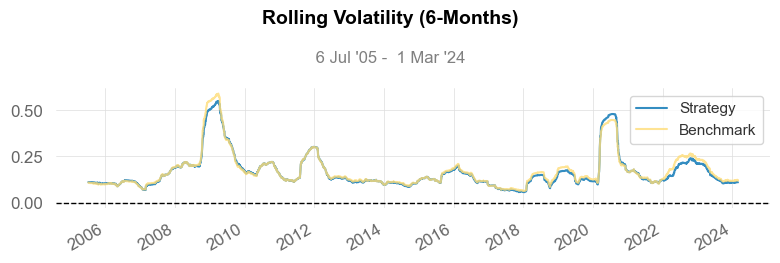

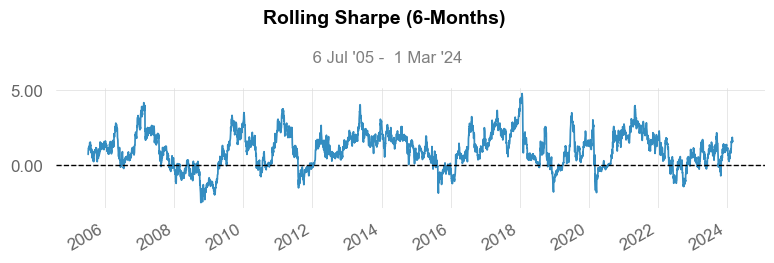

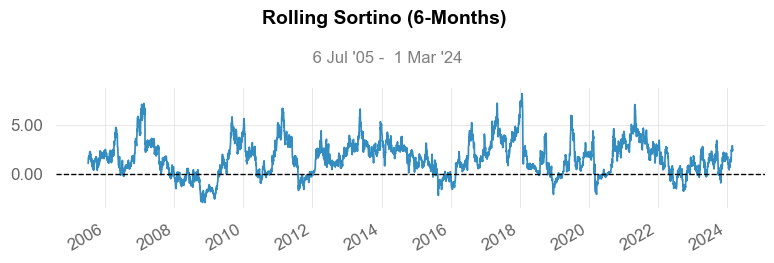

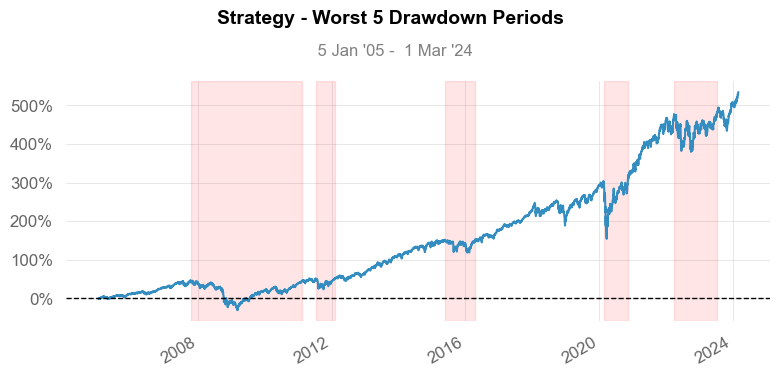

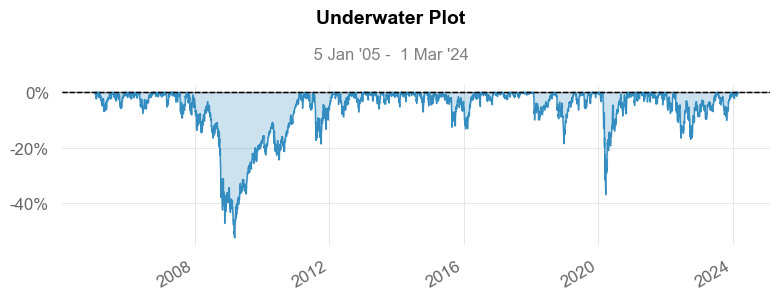

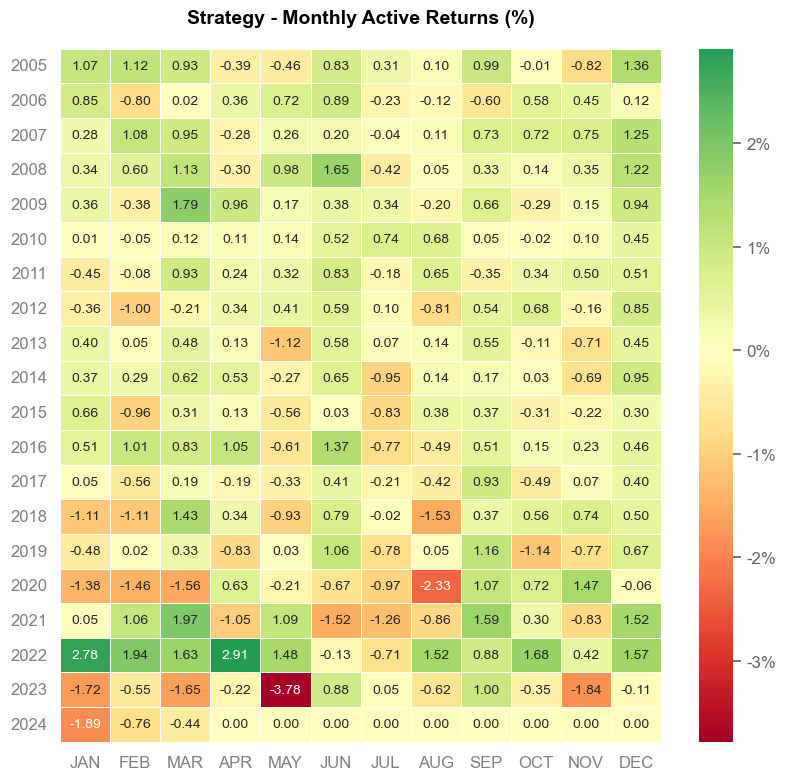

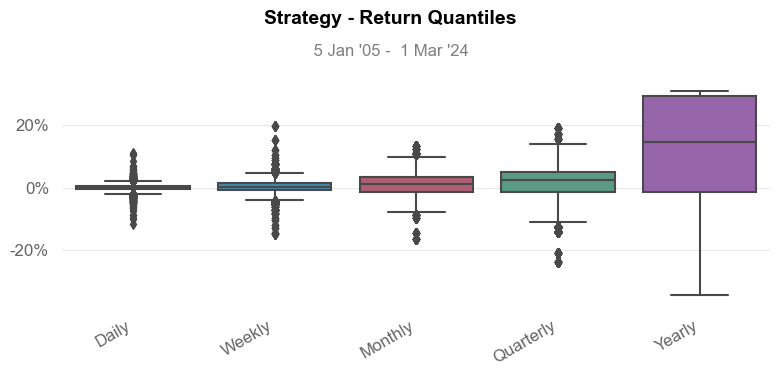

In [166]:
# Report
qs.reports.full(ewp_ret, 'SPY')

#### Risk Premia Portfolio

In [167]:
# Join
risk_premia = defense.join(sector_ret)

<AxesSubplot:xlabel='date'>

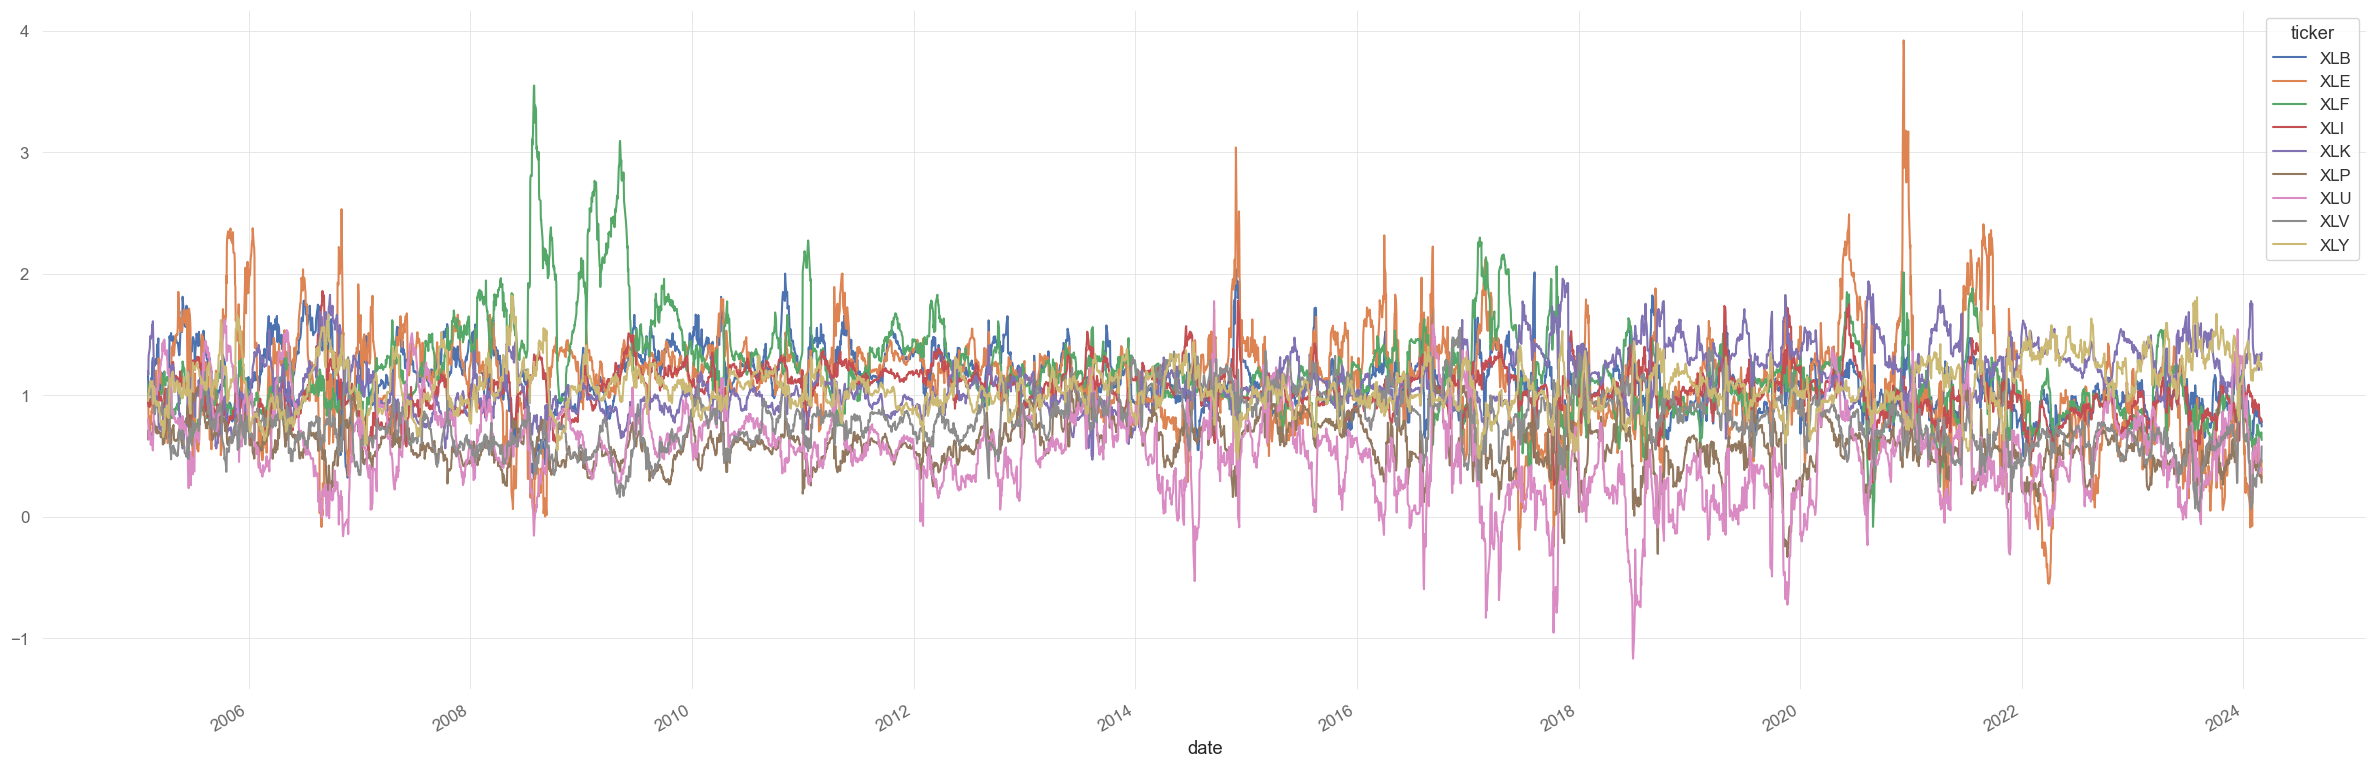

In [168]:
# Plot Beta
risk_premia.unstack('ticker')['beta'].plot(figsize=(30,10))

In [169]:
# Function to select top and bottom stocks
def select_long_short_stocks(group):
    top_stocks = group.nlargest(1, 'adj_weight')
    bottom_stocks = group.nsmallest(1, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors):
    df = data.copy(deep=True)
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    df['vol'] = df.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(7).std().shift(1))
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    top_bottom_stocks = df.groupby('date').apply(select_long_short_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    # Shift returns
    top_bottom_stocks['RET_01'] = top_bottom_stocks.groupby('ticker')['RET_01'].shift(-1)
    top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']
    total_ret = top_bottom_stocks.groupby('date').total_ret.sum()
    qs.reports.full(total_ret, 'SPY')
    return total_ret

------------------------------------------------------------
Creating Factor Ranks...
Factor: beta
------------------------------------------------------------
Creating Long/Short portfolio...
[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-11   2005-02-11
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          328.3%       427.57%
CAGR﹪                     5.41%        6.21%

Sharpe                     0.49         0.69
Prob. Sharpe Ratio         98.38%       99.84%
Smart Sharpe               0.46         0.64
Sortino                    0.69         0.95
Smart Sortino              0.64         0.89
Sortino/√2                 0.49         0.67
Smart Sortino/√2           0.46         0.63
Omega                      1.13         1.13

Max Drawdown               -56.47%      -42.81%
Longest DD Days            1982         1715
Volatility (ann.)          19.35%       14.15%
R^2                        0.0          0.0
Information Ratio          0.0          0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-01-09,2009-04-30,2012-09-18,1715,-42.812594,-41.652288
2,2019-09-30,2020-03-24,2021-04-13,562,-29.409940,-26.008971
3,2015-05-19,2015-09-03,2016-03-11,298,-17.298935,-16.692412
4,2022-04-13,2022-06-10,2022-09-08,149,-17.055289,-16.605194
5,2016-07-06,2016-11-04,2018-01-24,568,-14.271650,-13.110497


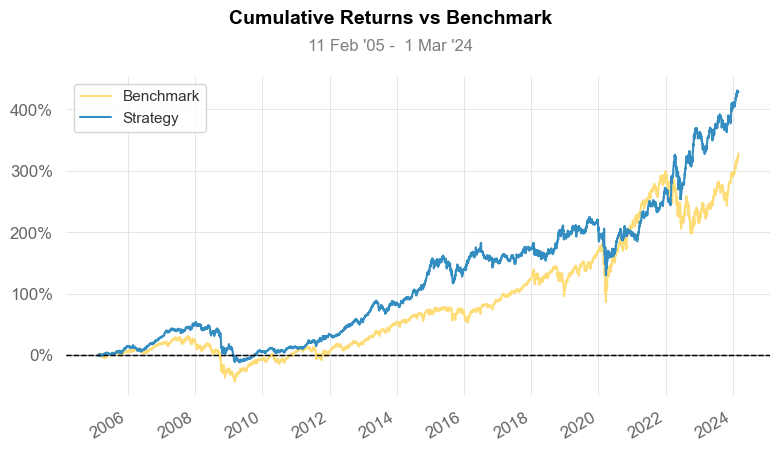

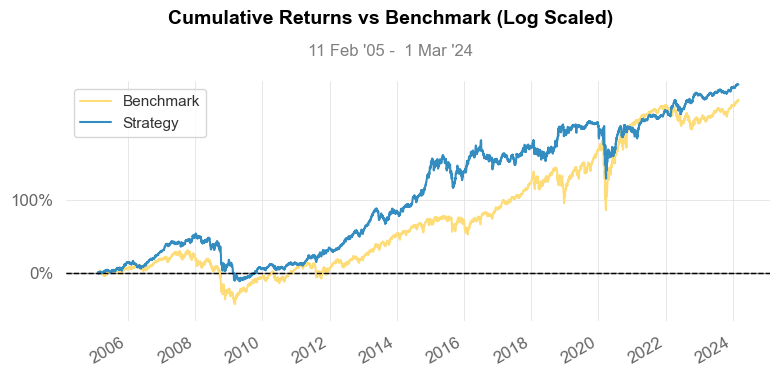

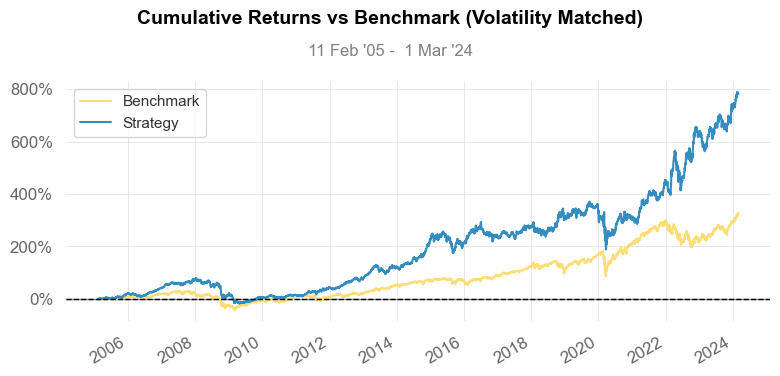

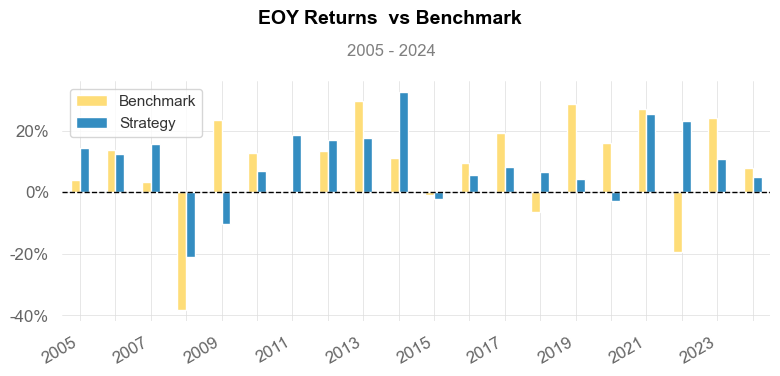

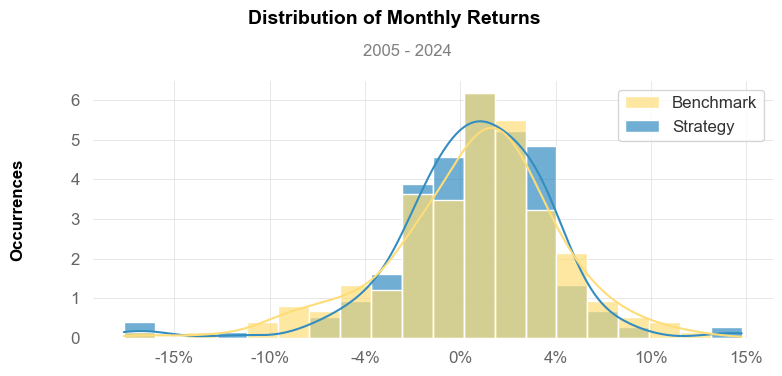

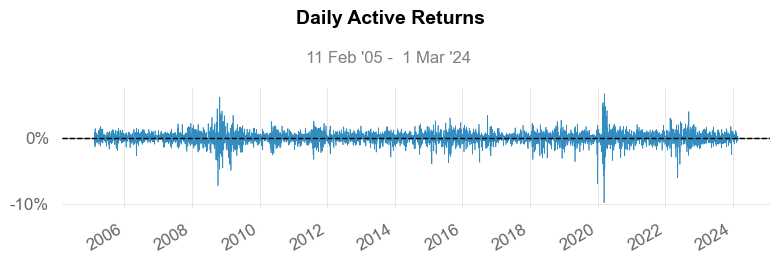

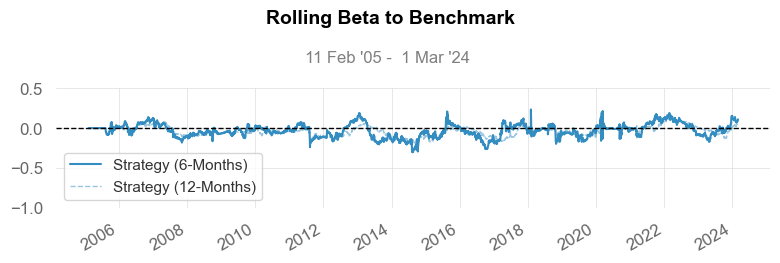

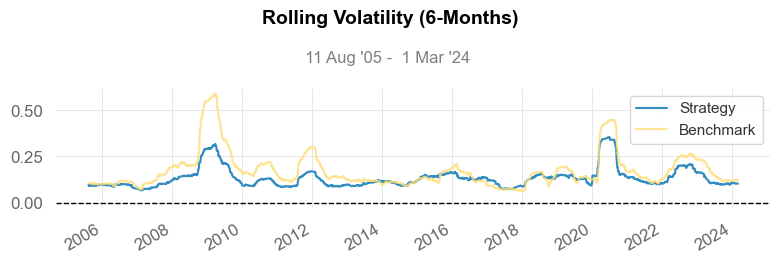

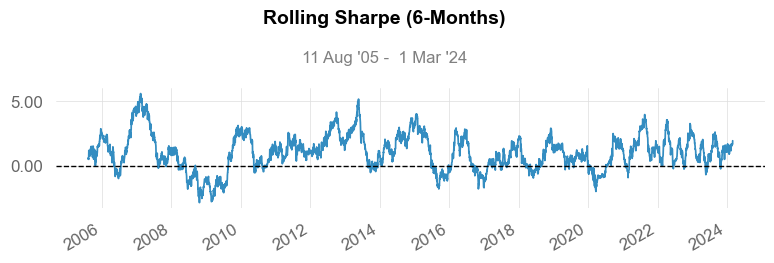

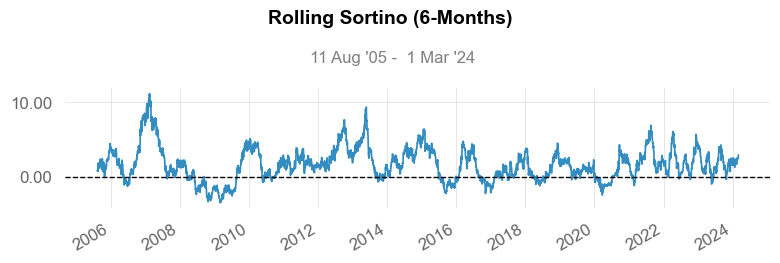

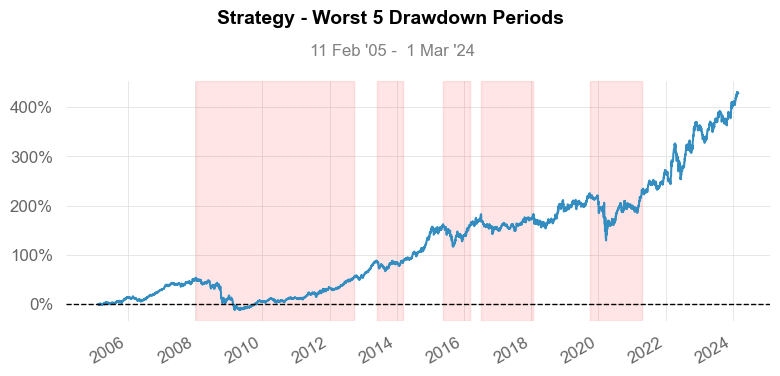

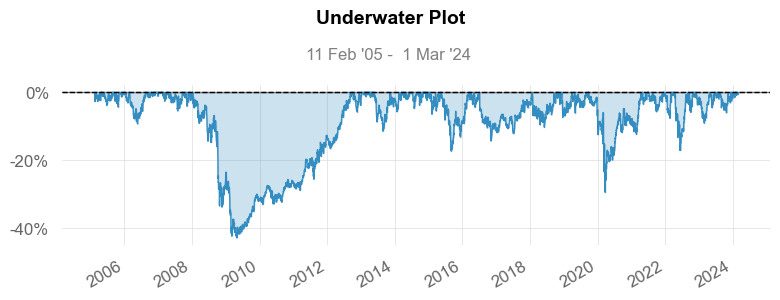

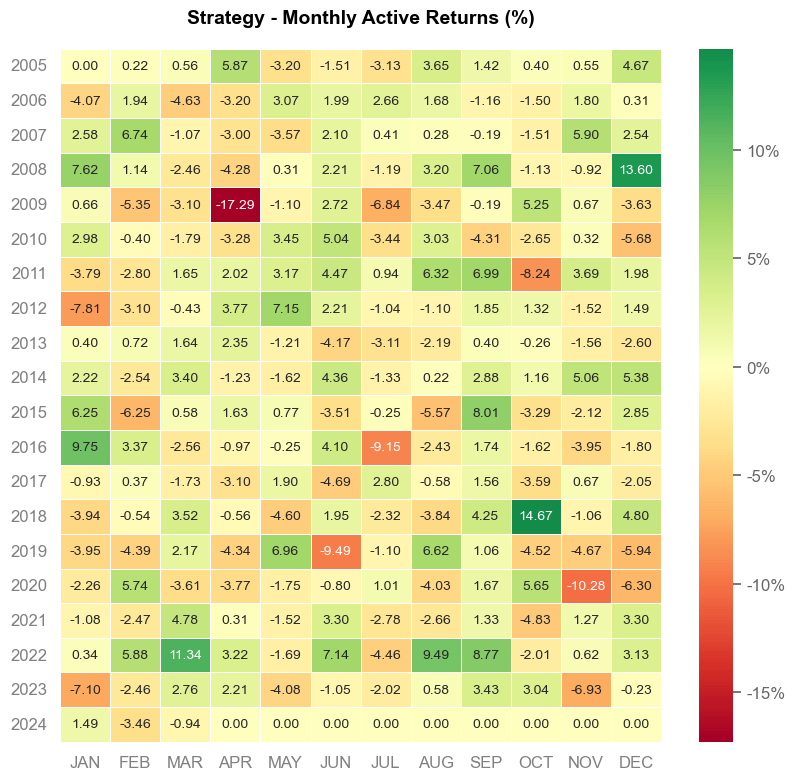

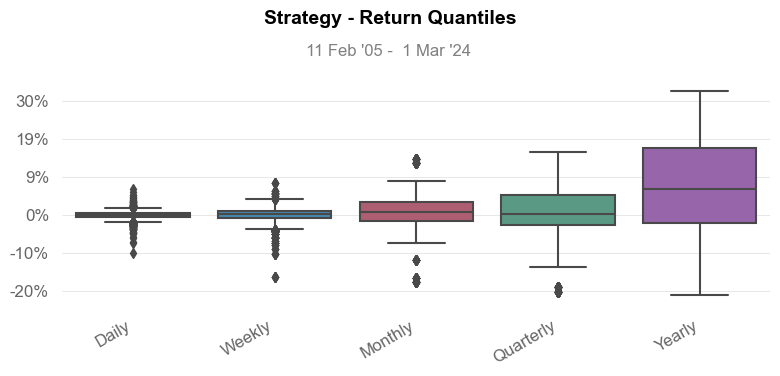

In [170]:
# Calculate portfolio return index
factors = ['beta']
port_ret = create_factor_port(risk_premia, factors)

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-11   2005-02-11
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          328.3%       427.57%
CAGR﹪                     5.41%        6.21%

Sharpe                     0.49         0.69
Prob. Sharpe Ratio         98.38%       99.84%
Smart Sharpe               0.46         0.64
Sortino                    0.69         0.95
Smart Sortino              0.64         0.89
Sortino/√2                 0.49         0.67
Smart Sortino/√2           0.46         0.63
Omega                      1.13         1.13

Max Drawdown               -56.47%      -42.81%
Longest DD Days            1982         1715
Volatility (ann.)          19.35%       14.15%
R^2                        0.0          0.0
Information Ratio          0.0          0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-01-09,2009-04-30,2012-09-18,1715,-42.812594,-41.652288
2,2019-09-30,2020-03-24,2021-04-13,562,-29.409940,-26.008971
3,2015-05-19,2015-09-03,2016-03-11,298,-17.298935,-16.692412
4,2022-04-13,2022-06-10,2022-09-08,149,-17.055289,-16.605194
5,2016-07-06,2016-11-04,2018-01-24,568,-14.271650,-13.110497


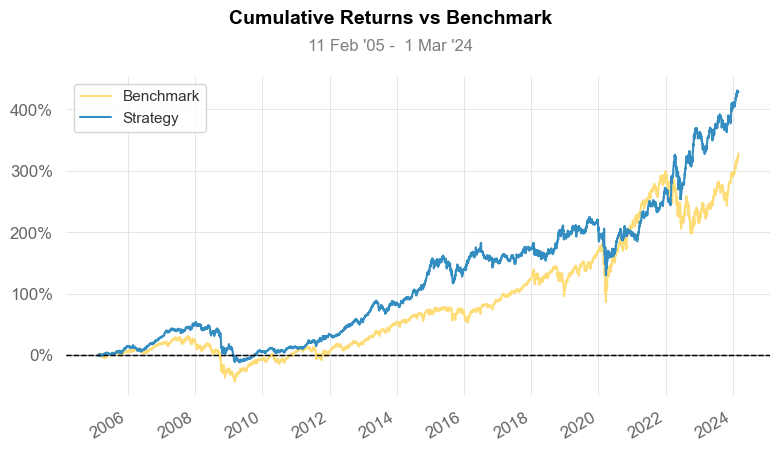

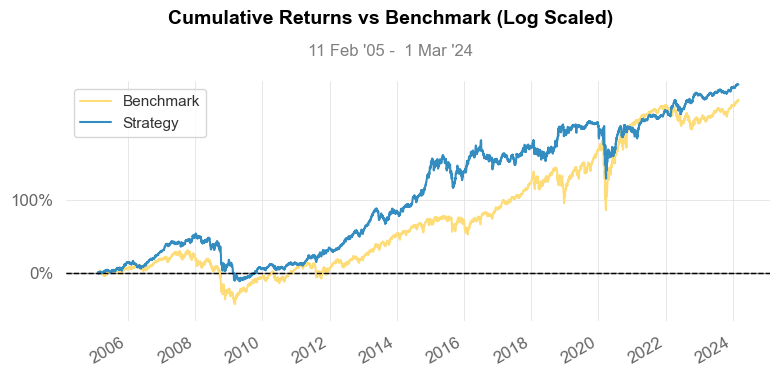

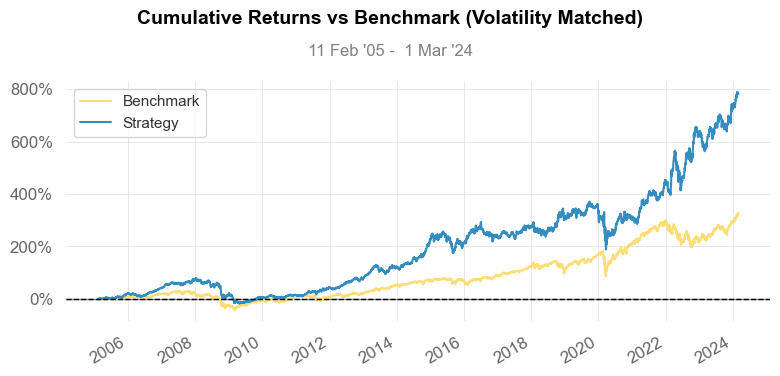

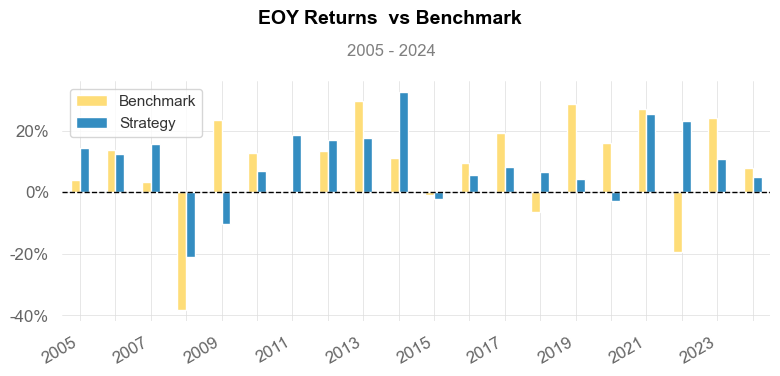

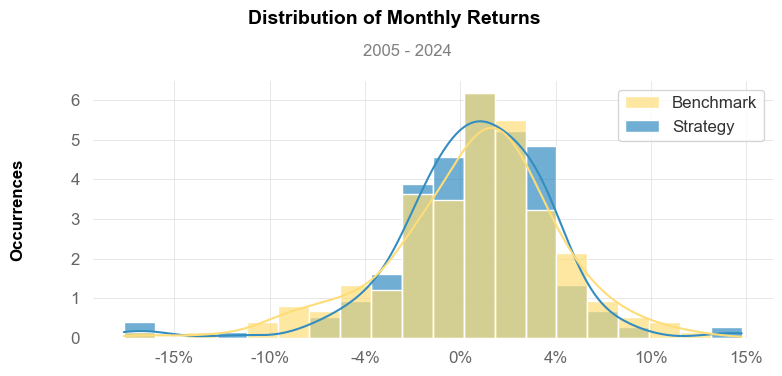

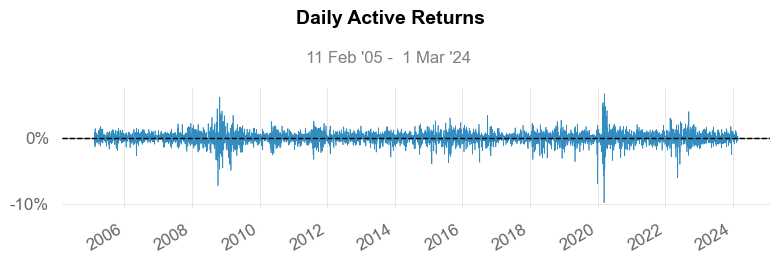

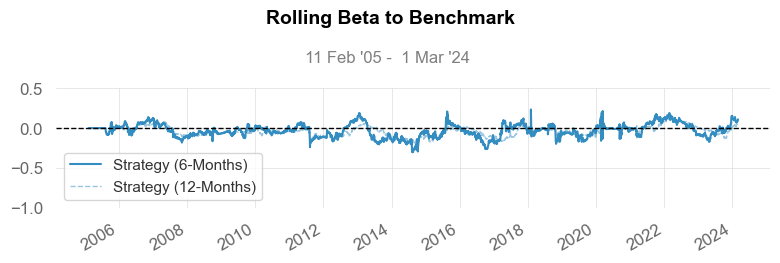

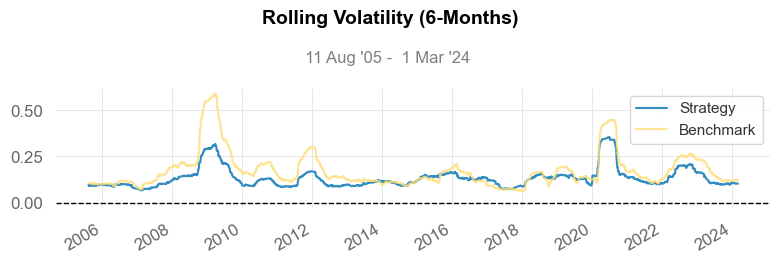

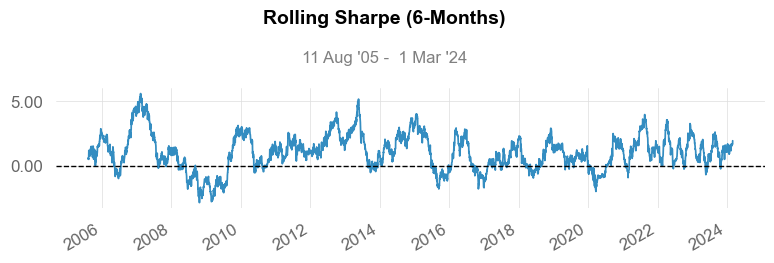

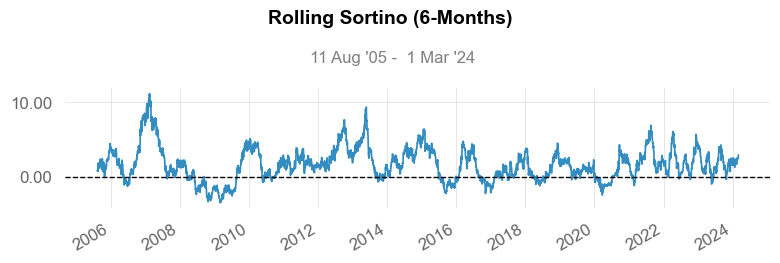

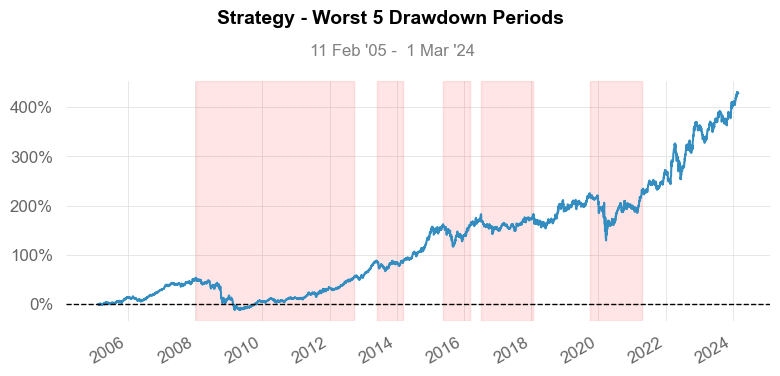

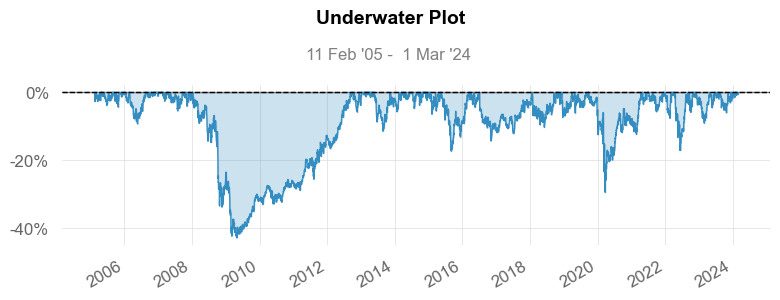

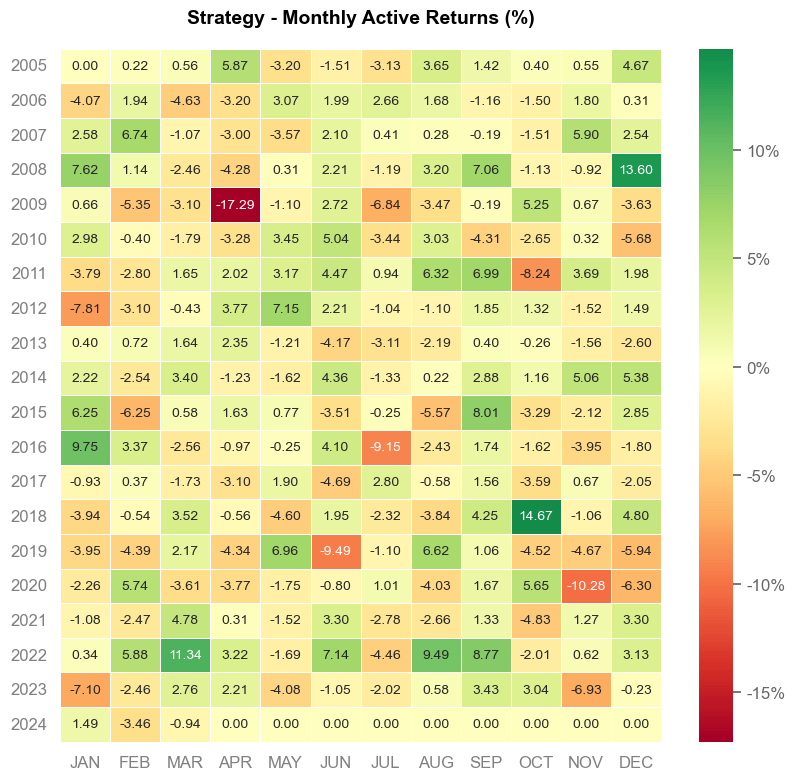

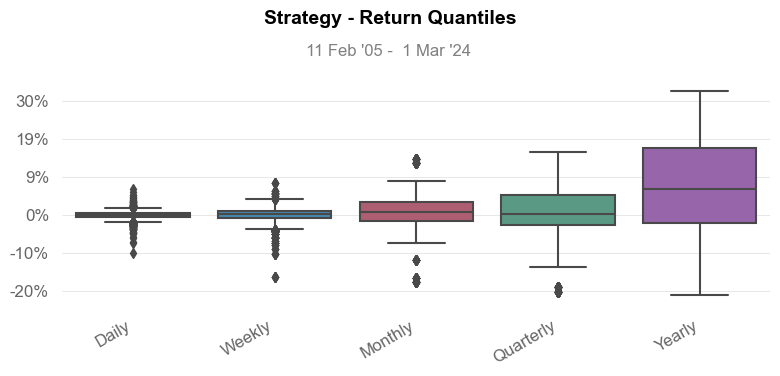

In [171]:
# Report
qs.reports.full(port_ret, 'SPY')